In [1]:
import glob
import os
import omegaconf

import pandas as pd
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isOld_ukb_without_residualization.csv"
label = "isOld"
max_iter = 2000
cv = 5

In [3]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[label]].dropna()
participants[:] = participants.sample(frac=1).values

In [4]:
len(participants)

6878

In [5]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [6]:
model_paths = get_model_paths(path_champollion)

In [7]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/13-19-08_28',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/Lobule_parietal_sup_left/09-48-31_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFint-SR_left/09-00-43_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SPoC_left/22-10-40_0',
 '/neurospin/dico/data/deep_folding/current/mod

In [8]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop(label, axis=1)
    Y = merged[label]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [9]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.46136915 0.49983007 0.48888889 0.49240788 0.50459087]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.47162162 0.49235313 0.49989079 0.50336124 0.49578126]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.50283217 0.51481631 0.48602516 0.49022368 0.50195365]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.4937854  0.48539408 0.52339117 0.49360515 0.51183109]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.499

In [10]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [11]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.489417,0.015064,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.492602,0.011129,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.499170,0.010186,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.501601,0.013908,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.484095,0.013301,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,0.482986,0.014890,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,0.512448,0.013988,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,0.512463,0.014068,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,0.528510,0.011840,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [12]:
df['side'] = df['region'].str.split('_').str[-1]

In [13]:
df.sort_values(by="roc_auc", ascending=True)

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
35,S.C.-S.Pe.C._left,0.473409,0.024568,09-49-03_0,SC-SPeC_left/09-49-03_0,/neurospin/dico/data/deep_folding/current/mode...,left
62,Sc.Cal.-S.Li._right,0.478343,0.015969,09-28-12_1,ScCal-SLi_right/09-28-12_1,/neurospin/dico/data/deep_folding/current/mode...,right
57,F.I.P._right,0.480467,0.011919,20-16-33_4,FIP_right/20-16-33_4,/neurospin/dico/data/deep_folding/current/mode...,right
20,OCCIPITAL_right,0.482890,0.011240,18-05-00_1,OCCIPITAL_right/18-05-00_1,/neurospin/dico/data/deep_folding/current/mode...,right
72,S.F.inter.-S.F.sup._right,0.482986,0.014890,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
71,S.T.i.-S.O.T.lat._left,0.516452,0.025368,09-36-46_0,STi-SOTlat_left/09-36-46_0,/neurospin/dico/data/deep_folding/current/mode...,left
14,S.F.inf.-BROCA-S.Pe.C.inf._left,0.516825,0.022662,12-25-50_0,SFinf-BROCA-SPeCinf_left/12-25-50_0,/neurospin/dico/data/deep_folding/current/mode...,left
46,S.Po.C._right,0.519909,0.013182,18-08-26_1,SPoC_right/18-08-26_1,/neurospin/dico/data/deep_folding/current/mode...,right
52,S.F.marginal-S.F.inf.ant._left,0.522426,0.015982,17-49-19_0,SFmarginal-SFinfant_left/17-49-19_0,/neurospin/dico/data/deep_folding/current/mode...,left


In [14]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 0.9))
    ax.set_title(title)


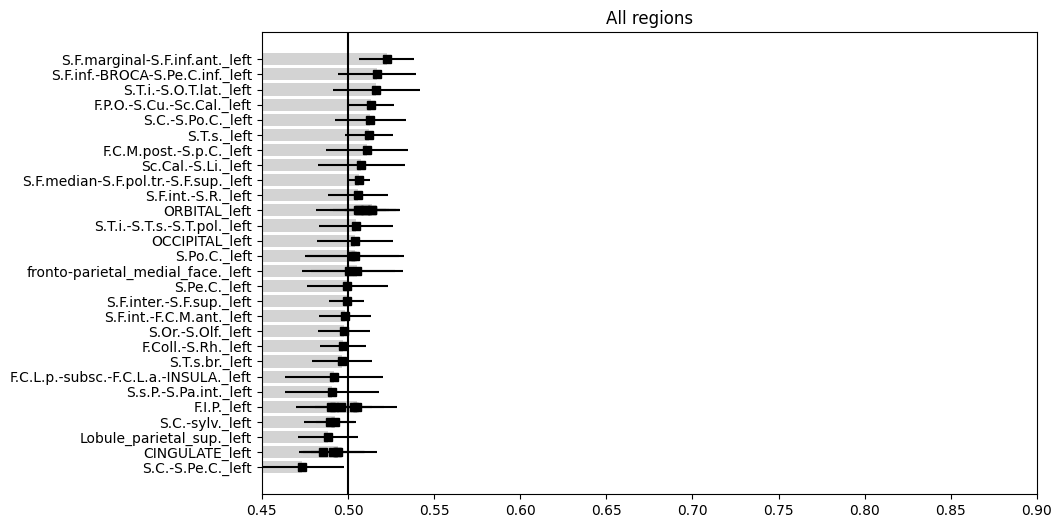

In [15]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

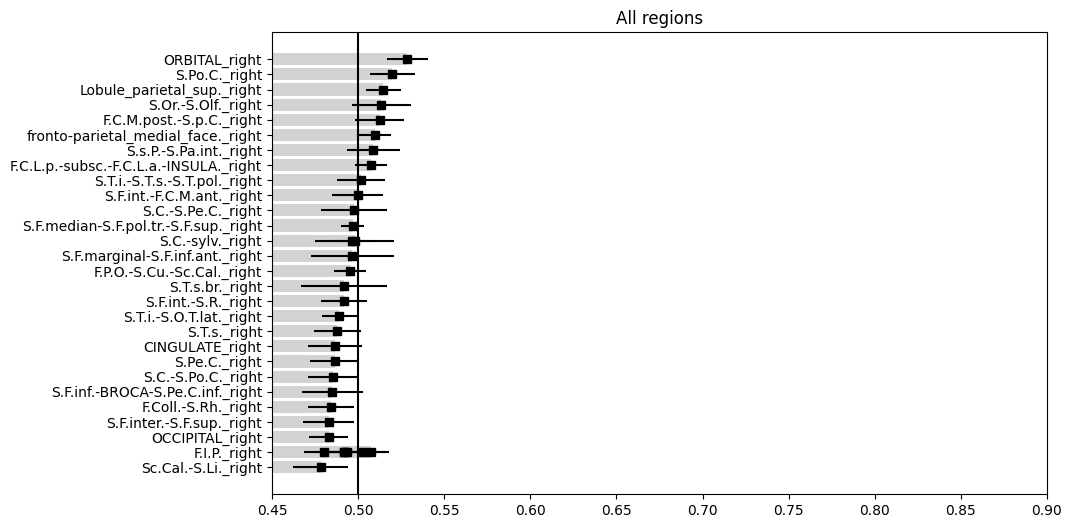

In [16]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [17]:
df.to_csv(output_filename)